In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('Heart_cleanedML.csv')

In [6]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155907 entries, 0 to 292384
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      155907 non-null  int64  
 1   BMI               155907 non-null  float64
 2   Smoking           155907 non-null  object 
 3   Stroke            155907 non-null  object 
 4   PhysicalHealth    155907 non-null  float64
 5   DiffWalking       155907 non-null  object 
 6   AgeCategory       155907 non-null  int64  
 7   Diabetic          155907 non-null  float64
 8   PhysicalActivity  155907 non-null  object 
 9   KidneyDisease     155907 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 13.1+ MB


In [12]:
df

,HeartDisease,BMI,Smoking,Stroke,PhysicalHealth,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,KidneyDisease
0,0,37.25,smokes,No,0.0,No,40,0.0,Yes,No
1,0,20.64,smokes,No,0.0,Yes,55,1.0,No,No
2,0,42.91,never smoked,No,0.0,No,65,0.0,Yes,No
3,0,21.97,never smoked,No,0.0,No,75,0.0,Yes,No
4,0,31.09,smokes,No,20.0,Yes,45,1.0,Yes,No
...,...,...,...,...,...,...,...,...,...,...
292374,0,26.58,smokes,No,0.0,Yes,75,0.0,Yes,No
292376,1,33.20,smokes,No,0.0,No,60,1.0,Yes,No
292377,0,36.54,never smoked,No,7.0,No,30,0.0,No,No
292380,1,27.41,smokes,No,7.0,Yes,60,1.0,No,No


In [14]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [16]:
categorical_features = ['Smoking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'KidneyDisease']
numeric_features = ['BMI', 'PhysicalHealth', 'AgeCategory', 'Diabetic']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# LogisticRegression

In [23]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

In [25]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', logreg)])

In [27]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

In [242]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['BMI',
                                                                          'PhysicalHealth',
                                                                          'AgeCategory',
                                                                          'Diabetic']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Smoking',
                                                                          'Stroke',
                                                                          'DiffWalking',
                                                                          'PhysicalActivity',
                                                                          'KidneyDisease'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [243]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [244]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__C': 10, 'classifier__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     39638
           1       0.27      0.72      0.39      7135

    accuracy                           0.66     46773
   macro avg       0.60      0.68      0.57     46773
weighted avg       0.83      0.66      0.70     46773

ROC AUC Score: 0.7495753209856844


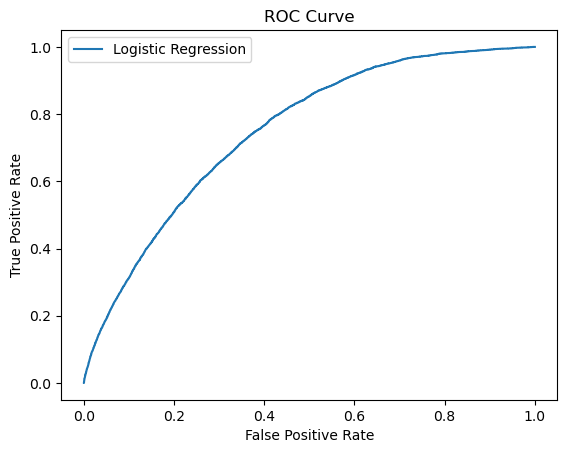

In [245]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# KNN

In [251]:
from sklearn.neighbors import KNeighborsClassifier

In [253]:
knn = KNeighborsClassifier()

In [255]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', knn)])

In [257]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [259]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['BMI',
                                                                          'PhysicalHealth',
                                                                          'AgeCategory',
                                                                          'Diabetic']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Smoking',
                                                                          'Stroke',
                                                                          'DiffWalking',
                                                                          'PhysicalActivity',
                                                                          'KidneyDisease'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [3, 5, 7, 9],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [260]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [261]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.90      0.70      0.78     39638
           1       0.25      0.55      0.34      7135

    accuracy                           0.68     46773
   macro avg       0.57      0.62      0.56     46773
weighted avg       0.80      0.68      0.72     46773

ROC AUC Score: 0.6761895062721271


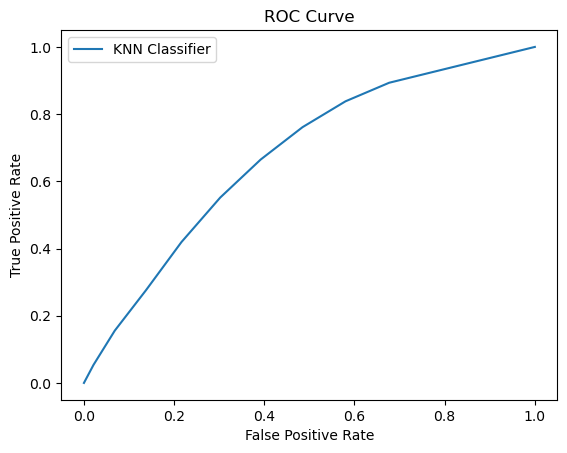

In [262]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="KNN Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# SVM

In [24]:
from sklearn.svm import SVC

In [26]:
svm = SVC(probability=True)

In [28]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),
                           ('classifier', svm)])

In [30]:
param_grid = {
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['linear'],
    'classifier__gamma': ['scale', 'auto']
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

In [ ]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [ ]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="SVM Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()